In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# PREPROCESSING
# ======================
def bandpass_filter(data):
    b, a = butter(2, [TREMOR_BAND[0]/(SAMPLING_RATE/2),
                   TREMOR_BAND[1]/(SAMPLING_RATE/2)], btype='bandpass')
    return filtfilt(b, a, data, axis=0)

print("Preprocessing data...")
# Apply filtering to each sample
X_filtered = np.array([bandpass_filter(sample) for sample in X])

# Normalize
scaler = StandardScaler()
X_reshaped = X_filtered.reshape(-1, 6)
scaler.fit(X_reshaped)
X_normalized = scaler.transform(X_reshaped).reshape(X.shape)

Preprocessing data...


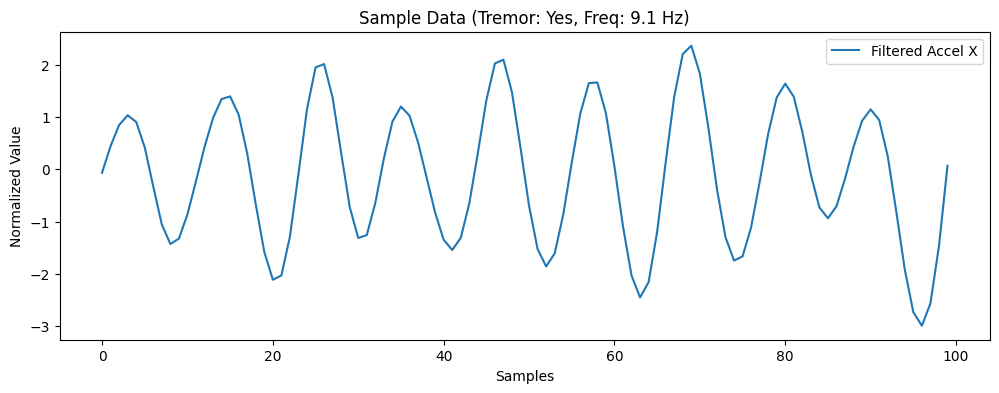

In [ ]:
# ======================
# VISUALIZE DATA
# ======================
plt.figure(figsize=(12, 4))
plt.plot(X_normalized[10, :, 0], label='Filtered Accel X')
plt.title(f"Sample Data (Tremor: {'Yes' if y_detect[10] else 'No'}, Freq: {y_freq[10]:.1f} Hz)")
plt.xlabel("Samples")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

In [ ]:
# ======================
# CNN-LSTM MODEL
# ======================
def create_detection_model():
    model = Sequential([
        Conv1D(32, 5, activation='relu', input_shape=(WINDOW_SIZE, 6)),
        MaxPooling1D(2),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Split data
X_train, X_test, y_train_detect, y_test_detect = train_test_split(
    X_normalized, y_detect, test_size=0.2, random_state=42
)


In [ ]:
# Train model
model = create_detection_model()
print("Training detection model...")
history = model.fit(X_train, y_train_detect,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2)

Training detection model...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.7753 - loss: 0.4307 - val_accuracy: 0.9837 - val_loss: 0.0720
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9771 - loss: 0.0796 - val_accuracy: 0.9875 - val_loss: 0.0537
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9839 - loss: 0.0488 - val_accuracy: 0.9787 - val_loss: 0.0637
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9842 - loss: 0.0516 - val_accuracy: 0.9950 - val_loss: 0.0214
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9888 - loss: 0.0301 - val_accuracy: 0.9900 - val_loss: 0.0336
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9899 - loss: 0.0414 - val_accuracy: 0.9925 - val_loss: 0.0231
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9927 - loss: 0.0258 - val_accuracy: 0.9750 - val_loss: 0.0642
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9920 - loss: 0.0319 - val_accuracy: 0.99

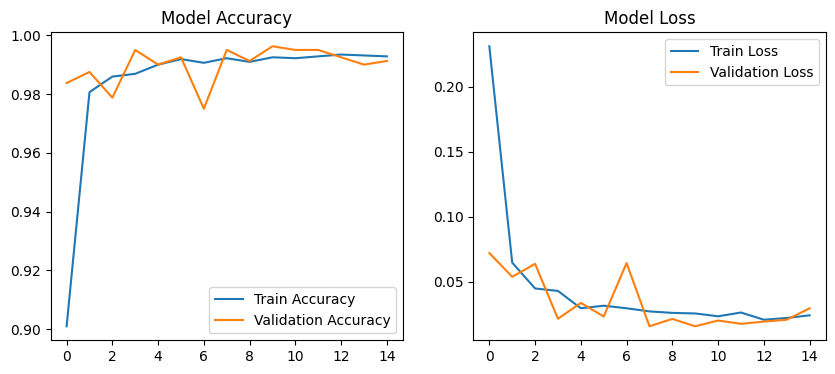

In [ ]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_detect)
print(f"\nTest Accuracy: {test_acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9922 - loss: 0.0438

Test Accuracy: 0.9920


In [ ]:
# ======================
# WAVELET-SVR FOR TREMOR CHARACTERIZATION
# ======================
def extract_wavelet_features(segment):
    coeffs = pywt.wavedec(segment[:, 0], 'db4', level=4)
    return np.concatenate([c.flatten() for c in coeffs])

print("Training tremor characterization models...")

Training tremor characterization models...


In [ ]:
# Get tremor samples only
tremor_indices = np.where(y_detect == 1)[0]
X_tremor = X_normalized[tremor_indices]
y_freq_tremor = y_freq[tremor_indices]
y_amp_tremor = y_amp[tremor_indices]


In [ ]:
# Extract features
X_wavelet = np.array([extract_wavelet_features(x) for x in X_tremor])

# Split tremor data for characterization
# We need to split X_tremor, y_freq_tremor, and y_amp_tremor together
X_train_w, X_test_w, y_train_freq, y_test_freq, y_train_amp, y_test_amp = train_test_split(
    X_wavelet, y_freq_tremor, y_amp_tremor, test_size=0.2, random_state=42
)

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [ ]:
# Train SVR models
freq_model = SVR(kernel='rbf', C=100, epsilon=0.1)
freq_model.fit(X_train_w, y_train_freq)

amp_model = SVR(kernel='rbf', C=100, epsilon=0.01)
amp_model.fit(X_train_w, y_train_amp)

# Evaluate
print(f"Frequency R²: {freq_model.score(X_test_w, y_test_freq):.4f}")
print(f"Amplitude R²: {amp_model.score(X_test_w, y_test_amp):.4f}")

Frequency R²: 0.7956
Amplitude R²: 0.8922


In [ ]:
!pip install tensorflow scikit-learn pywavelets pandas numpy matplotlib

In [ ]:
# ======================
# TFLITE CONVERSION
# ======================
print("Converting to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open('tremor_detector.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved!")

Converting to TFLite...
Saved artifact at '/tmp/tmpl9xwjzt_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135805389835728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135805389840144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135805389837648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135805389844176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135805389844752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135805389843792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135805389845328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135805389845904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135805389843600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135805389846288: TensorSpec(shape=(), dtype=tf.resource, name=N

In [ ]:
# ======================
# TEST INFERENCE
# ======================
# Select a random test sample
sample_idx = np.random.randint(0, len(X_test))
sample_data = X_test[sample_idx][np.newaxis, ...]

# Detection
detection_prob = model.predict(sample_data)[0][0]
print(f"\nSample Detection Test:")
print(f"True Tremor: {y_test_detect[sample_idx]}, Predicted Probability: {detection_prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step

Sample Detection Test:
True Tremor: 0, Predicted Probability: 0.0005


In [ ]:
# Characterization (if tremor detected)
if detection_prob > 0.5 and y_test_detect[sample_idx] == 1:
    features = extract_wavelet_features(sample_data[0])
    pred_freq = freq_model.predict([features])[0]
    pred_amp = amp_model.predict([features])[0]

    # Get the indices of tremor samples within the X_test array
    indices_of_tremor_in_X_test = np.where(y_test_detect == 1)[0]

    # Check if the selected sample is actually a tremor sample in the test set
    if sample_idx in indices_of_tremor_in_X_test:
        # Find the index of sample_idx within the array of tremor indices in the test set
        tremor_test_idx_in_subset = np.where(indices_of_tremor_in_X_test == sample_idx)[0][0]

        # Use this index to access y_test_freq and y_test_amp
        print(f"True Frequency: {y_test_freq[tremor_test_idx_in_subset]:.2f} Hz, Predicted: {pred_freq:.2f} Hz")
        print(f"True Amplitude: {y_test_amp[tremor_test_idx_in_subset]:.4f}g, Predicted: {pred_amp:.4f}g")
    else:
        print("Selected sample is not a tremor sample in the test set.")

### Evaluate Tremor Characterization Models

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

# Make predictions on the test set for tremor characterization
pred_freq_test = freq_model.predict(X_test_w)
pred_amp_test = amp_model.predict(X_test_w)

# Evaluate Frequency Model
freq_r2 = r2_score(y_test_freq, pred_freq_test)
freq_mae = mean_absolute_error(y_test_freq, pred_freq_test)

print(f"\nFrequency Model Evaluation:")
print(f"R² Score: {freq_r2:.4f}")
print(f"Mean Absolute Error: {freq_mae:.4f} Hz")

# Evaluate Amplitude Model
amp_r2 = r2_score(y_test_amp, pred_amp_test)
amp_mae = mean_absolute_error(y_test_amp, pred_amp_test)

print(f"\nAmplitude Model Evaluation:")
print(f"R² Score: {amp_r2:.4f}")
print(f"Mean Absolute Error: {amp_mae:.4f} g")


Frequency Model Evaluation:
R² Score: 0.7956
Mean Absolute Error: 0.8602 Hz

Amplitude Model Evaluation:
R² Score: 0.8922
Mean Absolute Error: 0.0301 g
